# Dataset building
Para organizar mejor los entrenamientos

## Imports

In [1]:
from fastai.vision.all import *
from PIL import Image
import pandas as pd
import numpy as np
import torch
import os
import random

## Definiciones dataset original

In [9]:
original_base_dir = "./FastAI_Data"
videos = [video_directory for video_directory in os.listdir(original_base_dir) if os.path.isdir(os.path.join(original_base_dir, video_directory))]

bites_img_folder = "Bocados_Masks"
non_bite_img_folder = "Rest_Masks"
videos

['02.1V0_trimmed_for_FastAI_RH',
 '03V0_trimmed_for_FastAI_RH',
 '11V0_trimmed_for_FastAI_RH',
 '23V1_trimmed_for_FastAI_LH',
 '7V0_trimmed_for_FastAI_RH']

## Crear nueva estructura para los dataset

In [20]:
print_structure = True     # Setear a true si se quiere ver la estructura que se construirá

# Base directory
loo_datasets_dir = "./loo_datasets"

# Crear estructura en base a los vídeos disponibles y los splits train, val y test
dataset_structure = {
    "train" : ["bite", "non_bite"],
    "validation" : ["bite", "non_bite"],
    "test" : ["bite", "non_bite"]
}

datasets_structure = {}

for video in videos:
    datasets_structure[f"{video.split("_")[0]}_out"] = dataset_structure

if print_structure:
    print(datasets_structure)

{'02.1V0_out': {'train': ['bite', 'non_bite'], 'validation': ['bite', 'non_bite'], 'test': ['bite', 'non_bite']}, '03V0_out': {'train': ['bite', 'non_bite'], 'validation': ['bite', 'non_bite'], 'test': ['bite', 'non_bite']}, '11V0_out': {'train': ['bite', 'non_bite'], 'validation': ['bite', 'non_bite'], 'test': ['bite', 'non_bite']}, '23V1_out': {'train': ['bite', 'non_bite'], 'validation': ['bite', 'non_bite'], 'test': ['bite', 'non_bite']}, '7V0_out': {'train': ['bite', 'non_bite'], 'validation': ['bite', 'non_bite'], 'test': ['bite', 'non_bite']}}


In [21]:
os.makedirs(loo_datasets_dir, exist_ok=True)

for dataset, splits in datasets_structure.items():
    print(f"Creating: {dataset}")
    loo_dataset_dir = os.path.join(loo_datasets_dir, dataset)
    os.makedirs(loo_dataset_dir, exist_ok=True)
    for split, classes in splits.items():
        split_dir = os.path.join(loo_dataset_dir, split)
        print(f"\tCreating Split folder: {split_dir}")
        os.makedirs(split_dir, exist_ok=True)
        for img_class in classes:
            img_dir = os.path.join(split_dir, img_class)
            print(f"\t\tCreating class dir: {img_dir}")
            os.makedirs(img_dir, exist_ok=True)        

Creating: 02.1V0_out
	Creating Split folder: ./loo_datasets\02.1V0_out\train
		Creating class dir: ./loo_datasets\02.1V0_out\train\bite
		Creating class dir: ./loo_datasets\02.1V0_out\train\non_bite
	Creating Split folder: ./loo_datasets\02.1V0_out\validation
		Creating class dir: ./loo_datasets\02.1V0_out\validation\bite
		Creating class dir: ./loo_datasets\02.1V0_out\validation\non_bite
	Creating Split folder: ./loo_datasets\02.1V0_out\test
		Creating class dir: ./loo_datasets\02.1V0_out\test\bite
		Creating class dir: ./loo_datasets\02.1V0_out\test\non_bite
Creating: 03V0_out
	Creating Split folder: ./loo_datasets\03V0_out\train
		Creating class dir: ./loo_datasets\03V0_out\train\bite
		Creating class dir: ./loo_datasets\03V0_out\train\non_bite
	Creating Split folder: ./loo_datasets\03V0_out\validation
		Creating class dir: ./loo_datasets\03V0_out\validation\bite
		Creating class dir: ./loo_datasets\03V0_out\validation\non_bite
	Creating Split folder: ./loo_datasets\03V0_out\test
		

## Extraer paths de imágenes del dataset original

In [22]:
original_base_dir = "./FastAI_Data"
videos_paths = {}

bite_imgs = 0
non_bite_imgs = 0
for video in videos:
    videos_paths[video] = {
        "bite" : [],
        "non_bite" : []
    }
    videos_paths[video]["bite"].extend(get_image_files(os.path.join(original_base_dir, video, bites_img_folder)))
    videos_paths[video]["non_bite"].extend(get_image_files(os.path.join(original_base_dir, video, non_bite_img_folder)))
    bite_imgs += len(videos_paths[video]["bite"])
    non_bite_imgs += len(videos_paths[video]["non_bite"])

print("## bite imgs ##")
print(bite_imgs)
print("## non_bite imgs ##")
print(non_bite_imgs)
print("## total videos ##")
print(len(videos_paths))


## bite imgs ##
1224
## non_bite imgs ##
9763
## total videos ##
5


## Función preadaptación imágenes

In [23]:
# Definiciones de cada tag en binario y conversión para el dataset (se indicará si estamos interesados en derecha o izquierda)
hands_categories = [{'binary': 0, 'tag': 'background',        'converted': 0},
                    {'binary': 1, 'tag': 'left hand',         'converted': 255},
                    {'binary': 2, 'tag': 'right hand',        'converted': 255},
                    {'binary': 3, 'tag': 'left hand object',  'converted': 128},
                    {'binary': 4, 'tag': 'right hand object', 'converted': 128},
                    {'binary': 5, 'tag': 'both hands object', 'converted': 128},]

def normalize_image(image : np.array):
    numpy_image = np.array(image)
    mask = ((numpy_image != 1)
            & (numpy_image != 2)
            & (numpy_image != 3)
            & (numpy_image != 4)
            & (numpy_image != 5))
    numpy_image[mask] = 0
    numpy_image[numpy_image == 1] = 255
    numpy_image[numpy_image == 2] = 255
    numpy_image[numpy_image == 3] = 128
    numpy_image[numpy_image == 4] = 128
    numpy_image[numpy_image == 5] = 128
    pil_image = Image.fromarray(numpy_image.astype(np.uint8))
    return numpy_image, pil_image

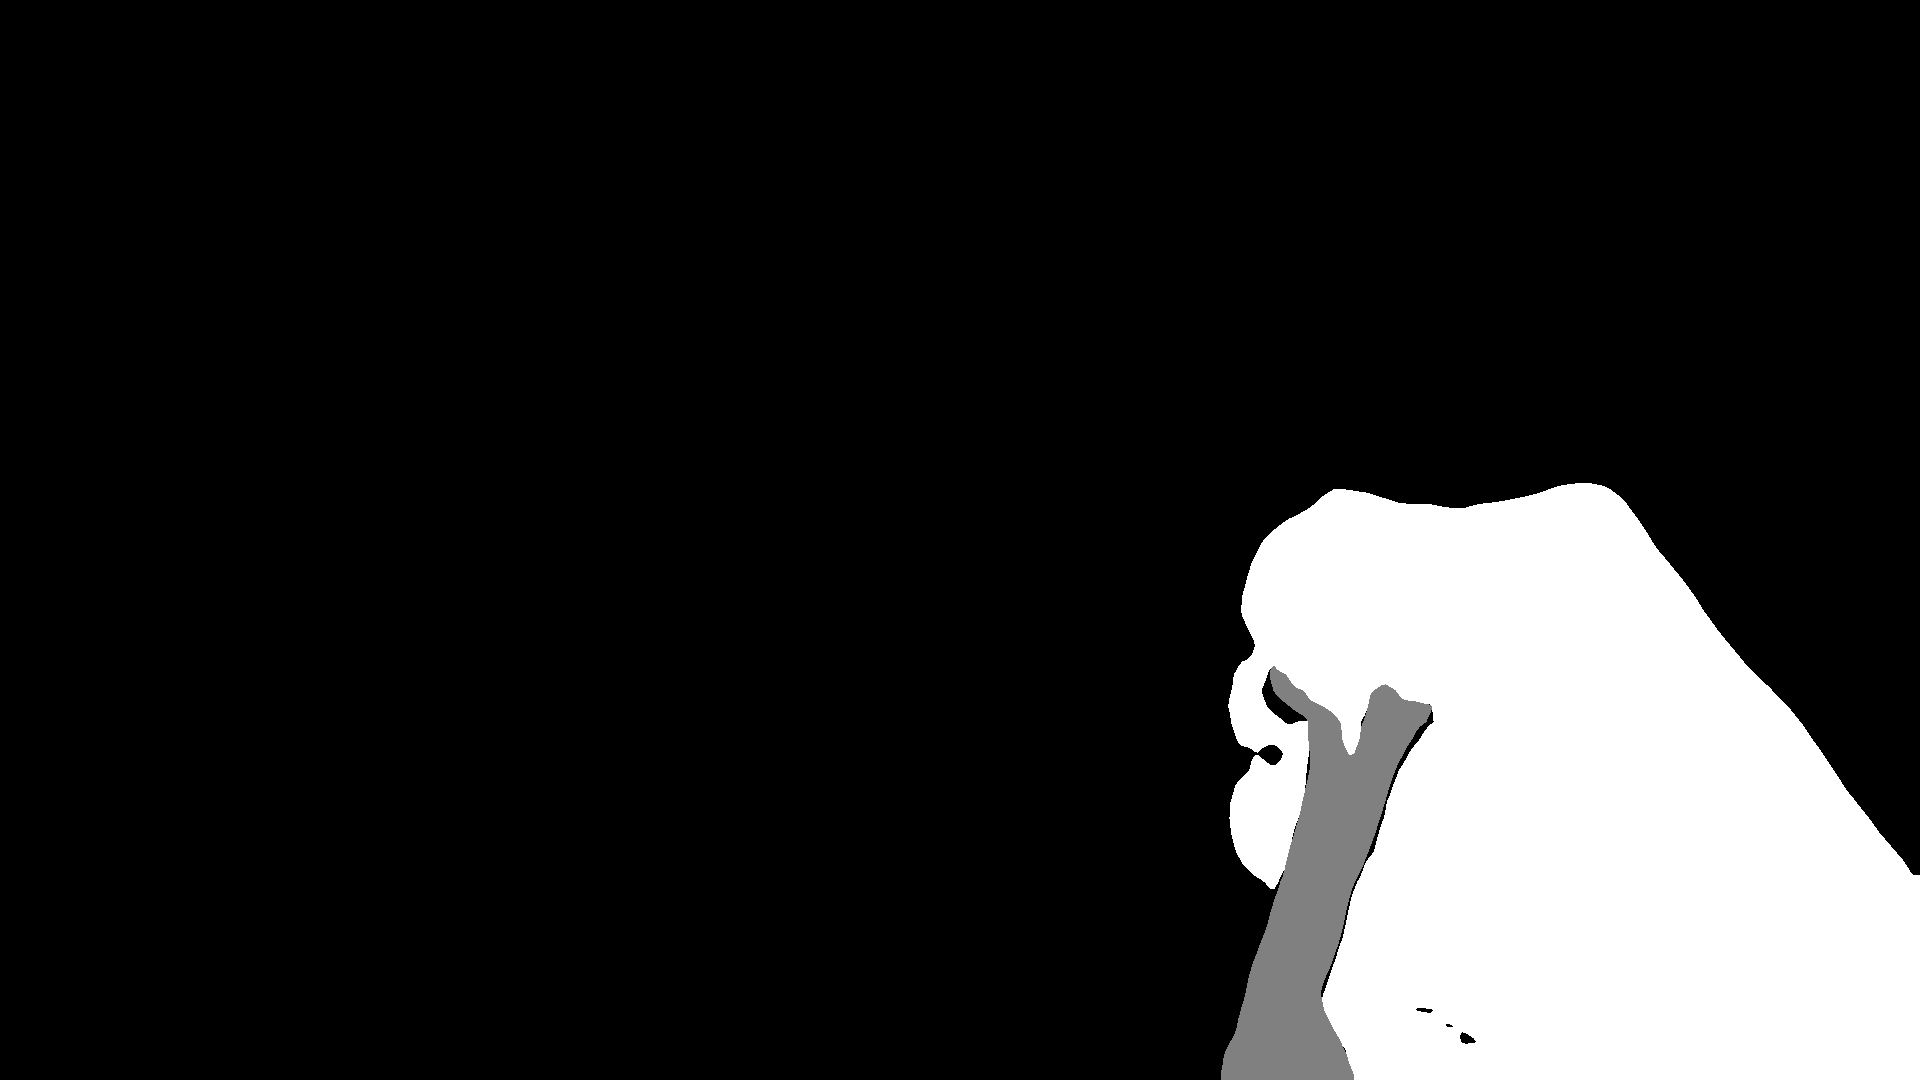

In [24]:
random_image = Image.open(random.choice(videos_paths[random.choice(list(videos_paths.keys()))]["bite"]))
np_image, pil_image = normalize_image(random_image)
pil_image

## Finalmente, enviar imágenes a los datasets

In [25]:
loo_datasets_dir

'./loo_datasets'

In [26]:
for dataset, splits in datasets_structure.items():
    dataset_id = dataset.split("_")[0]
    print(dataset_id)
    n_train_video_bite = 0
    n_val_video_bite = 0
    n_train_video_non_bite = 0
    n_val_video_non_bite = 0
    for og_video_dir, classes in videos_paths.items():
        print(classes["bite"])
        randomized_bites = random.sample(classes["bite"], len(classes["bite"]))
        randomized_n_bites = random.sample(classes["non_bite"], len(classes["non_bite"]))
        if dataset_id in og_video_dir:
            # Save 100% of this og_video in test split for this dataset.
            print(f"Saving {og_video_dir} as test")

            for index, bite_img_path in enumerate(randomized_bites):
                bite_img = Image.open(bite_img_path)
                np_image, pil_image = normalize_image(image=bite_img)
                pil_image.save(os.path.join(loo_datasets_dir, dataset, "test", "bite", f"{index}.png"))

            for index, non_bite_img_path in enumerate(randomized_n_bites):
                non_bite_img = Image.open(non_bite_img_path)
                np_image, pil_image = normalize_image(image=non_bite_img)
                pil_image.save(os.path.join(loo_datasets_dir, dataset, "test", "non_bite", f"{index}.png"))
            
            continue

        # Send 80% data to train and 20% to validation
        total_length = len(randomized_bites)
        split_index = int(total_length * 0.8)
        train_bites = randomized_bites[:split_index]
        val_bites = randomized_bites[split_index:]

        for bite_img_path in train_bites:
            bite_img = Image.open(bite_img_path)
            np_image, pil_image = normalize_image(image=bite_img)
            pil_image.save(os.path.join(loo_datasets_dir, dataset, "train", "bite", f"{n_train_video_bite}.png"))
            n_train_video_bite += 1

        for bite_img_path in val_bites:
            non_bite_img = Image.open(bite_img_path)
            np_image, pil_image = normalize_image(image=non_bite_img)
            pil_image.save(os.path.join(loo_datasets_dir, dataset, "validation", "bite", f"{n_val_video_bite}.png"))
            n_val_video_bite += 1
        

        total_length = len(randomized_n_bites)
        split_index = int(total_length * 0.8)
        train_n_bites = randomized_n_bites[:split_index]
        val_n_bites = randomized_n_bites[split_index:]

        for non_bite_img_path in train_n_bites:
            bite_img = Image.open(non_bite_img_path)
            np_image, pil_image = normalize_image(image=bite_img)
            pil_image.save(os.path.join(loo_datasets_dir, dataset, "train", "non_bite", f"{n_train_video_non_bite}.png"))
            n_train_video_non_bite += 1

        for non_bite_img_path in val_n_bites:
            non_bite_img = Image.open(non_bite_img_path)
            np_image, pil_image = normalize_image(image=non_bite_img)
            pil_image.save(os.path.join(loo_datasets_dir, dataset, "validation", "non_bite", f"{n_val_video_non_bite}.png"))
            n_val_video_non_bite += 1   

02.1V0
[Path('FastAI_Data/02.1V0_trimmed_for_FastAI_RH/Bocados_Masks/1045.png'), Path('FastAI_Data/02.1V0_trimmed_for_FastAI_RH/Bocados_Masks/1046.png'), Path('FastAI_Data/02.1V0_trimmed_for_FastAI_RH/Bocados_Masks/1047.png'), Path('FastAI_Data/02.1V0_trimmed_for_FastAI_RH/Bocados_Masks/1048.png'), Path('FastAI_Data/02.1V0_trimmed_for_FastAI_RH/Bocados_Masks/1049.png'), Path('FastAI_Data/02.1V0_trimmed_for_FastAI_RH/Bocados_Masks/1142.png'), Path('FastAI_Data/02.1V0_trimmed_for_FastAI_RH/Bocados_Masks/1143.png'), Path('FastAI_Data/02.1V0_trimmed_for_FastAI_RH/Bocados_Masks/1156.png'), Path('FastAI_Data/02.1V0_trimmed_for_FastAI_RH/Bocados_Masks/1157.png'), Path('FastAI_Data/02.1V0_trimmed_for_FastAI_RH/Bocados_Masks/1221.png'), Path('FastAI_Data/02.1V0_trimmed_for_FastAI_RH/Bocados_Masks/1222.png'), Path('FastAI_Data/02.1V0_trimmed_for_FastAI_RH/Bocados_Masks/1223.png'), Path('FastAI_Data/02.1V0_trimmed_for_FastAI_RH/Bocados_Masks/1224.png'), Path('FastAI_Data/02.1V0_trimmed_for_FastAI